Right, this time, instead of predicting one day at a time and then only being able to predict multiple days into the future. We are going to predict n days at a time.

## Data Preprecessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
win_len = 100  # how many days the model uses to predict the next n days
pred_len = 100 # How many days to predict

### Fetch Latest Data

In [3]:
import yfinance as yf

In [4]:
msft = yf.Ticker("BTC-USD")
btc_usd_hist = msft.history(period="max")

### Load and split data

In [5]:
dataset = btc_usd_hist['Close']
data = dataset.values.reshape(-1,1) # get np array version

In [6]:
def train_test_split(data, pred_len):
    data_train = data[:-pred_len]
    data_test = data[-pred_len:]
    return data_train, data_test

In [7]:
train, test = train_test_split(data, pred_len)
print('Train: {} days, Test: {} days'.format(len(train), len(test)))

Train: 1945 days, Test: 100 days


### Feature Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

### Windowing Data

In [10]:
train.shape

(1945, 1)

In [11]:
X_train = np.array([train_scaled[i-win_len:i, 0] for i in range(win_len+pred_len, len(train))])

In [12]:
y_train = np.array([train_scaled[i:i+pred_len, 0] for i in range(win_len, len(train)-pred_len)])

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [15]:
def build_lstm_model(data, num_neurons = 50, activ_func='linear', 
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    # layer 1
    model.add(LSTM(units=num_neurons, return_sequences=True, input_shape=(data.shape[1], 1)))
    model.add(Dropout(dropout))
    # layer 2
    model.add(LSTM(units=num_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    # layer 3
    model.add(LSTM(units=num_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    # layer 4
    model.add(LSTM(units=num_neurons))
    model.add(Dropout(dropout))
    # ouput layer
    model.add(Dense(units=pred_len))
    # model.add(Activation(activ_func))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [16]:
model = build_lstm_model(X_train)

## Training the Model

In [17]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Train on 1745 samples
Epoch 1/100
1745/1745 [==============================] - 9s 5ms/sample - loss: 0.0294
Epoch 2/100
1745/1745 [==============================] - 1s 515us/sample - loss: 0.0089
Epoch 3/100
1745/1745 [==============================] - 1s 517us/sample - loss: 0.0074
Epoch 4/100
1745/1745 [==============================] - 1s 510us/sample - loss: 0.0065
Epoch 5/100
1745/1745 [==============================] - 1s 509us/sample - loss: 0.0055
Epoch 6/100
1745/1745 [==============================] - 1s 512us/sample - loss: 0.0043
Epoch 7/100
1745/1745 [==============================] - 1s 509us/sample - loss: 0.0038
Epoch 8/100
1745/1745 [==============================] - 1s 512us/sample - loss: 0.0037
Epoch 9/100
1745/1745 [==============================] - 1s 510us/sample - loss: 0.0034
Epoch 10/100
1745/1745 [==============================] - 1s 515us/sample - loss: 0.0032
Epoch 11/100
1745/1745 [==============================] - 1s 510us/sample - loss: 0.0031s - los
Epo

1745/1745 [==============================] - 1s 520us/sample - loss: 0.0011
Epoch 93/100
1745/1745 [==============================] - 1s 512us/sample - loss: 0.0011
Epoch 94/100
1745/1745 [==============================] - 1s 512us/sample - loss: 0.0012
Epoch 95/100
1745/1745 [==============================] - 1s 504us/sample - loss: 0.0012
Epoch 96/100
1745/1745 [==============================] - 1s 510us/sample - loss: 0.0012
Epoch 97/100
1745/1745 [==============================] - 1s 517us/sample - loss: 0.0011
Epoch 98/100
1745/1745 [==============================] - 1s 517us/sample - loss: 0.0011
Epoch 99/100
1745/1745 [==============================] - 1s 508us/sample - loss: 0.0011
Epoch 100/100
1745/1745 [==============================] - 1s 509us/sample - loss: 0.0011


## Testing the Model

### Get Predicted Values

Need to use predict in a for loop, where it takes the previous win_len days and predicts the next 7, then shifts along and predicts the next day where the 60th input entry is the previous prediction.

PREDICTIONS CANNOT BE BASED ON TEST DATA - Unlike Fillipos and that Udemy course

In [18]:
inputs = sc.transform(train[-win_len:])

In [19]:
X_test = np.reshape(inputs, (1, inputs.shape[0], inputs.shape[1]))

In [20]:
prediction = model.predict(X_test)

In [21]:
preds = sc.inverse_transform(prediction.reshape(-1,1))

### Plot predicted values versus expected values

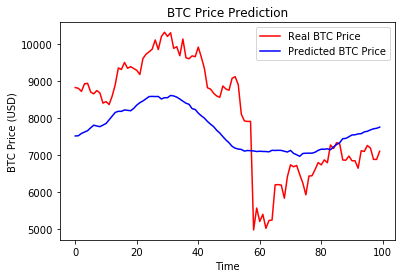

In [22]:
plt.plot(test, color = 'red', label = 'Real BTC Price')
plt.plot(preds, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.show()